In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
from ml_robot.metrics import auc,rmse
import pickle
#%matplotlib inline

Tensorflow is not installed properly
filter_accel is not installed properly


# Functions

In [28]:
def logloss(y,yp):
    yp = np.clip(yp,1e-5,1-1e-5)
    return -y*np.log(yp)-(1-y)*np.log(1-yp)
    
def reverse(tr,te):
    reverse_list = [0,1,2,3,4,5,6,7,8,11,15,16,18,19,
                22,24,25,26,27,41,29,
                32,35,37,40,48,49,47,
                55,51,52,53,60,61,62,103,65,66,67,69,
                70,71,74,78,79,
                82,84,89,90,91,94,95,96,97,99,
                105,106,110,111,112,118,119,125,128,
                130,133,134,135,137,
                140,144,145,147,151,155,157,159,
                161,162,163,164,167,168,
                170,171,173,175,176,179,
                180,181,184,185,187,189,
                190,191,195,196,199]
    reverse_list = ['var_%d'%i for i in reverse_list]
    for col in tr.columns:
        colx = '_'.join(col.split('_')[:2])
        if colx in reverse_list and 'count' not in col: 
            tr[col] = tr[col]*(-1)
            te[col] = te[col]*(-1)
    return tr,te

def scale(tr,te):
    for col in tr.columns:
        if col.startswith('var_') and 'count' not in col:
            mean,std = tr[col].mean(),tr[col].std()
            tr[col] = (tr[col]-mean)/std
            if col in te.columns:
                te[col] = (te[col]-mean)/std
    return tr,te

def getp_vec_sum(x,x_sort,y,std,c=0.5):
    # x is sorted
    left = x - std/c
    right = x + std/c
    p_left = np.searchsorted(x_sort,left)
    p_right = np.searchsorted(x_sort,right)
    p_right[p_right>=y.shape[0]] = y.shape[0]-1
    p_left[p_left>=y.shape[0]] = y.shape[0]-1
    return (y[p_right]-y[p_left])

def get_prob(tr,col,x_query=None,smooth=3,silent=1):
    std = tr[col].std()
    N = tr.shape[0]
    tr = tr.drop_duplicates(subset=col)
    if silent==0:
        print("null ratio %.4f"%(tr.shape[0]/N))
    df = tr.groupby(col).agg({'target':['sum','count']})
    cols = ['sum_y','count_y']
    df.columns = cols
    df = df.reset_index()
    df = df.sort_values(col)
    y,c = cols
    
    df[y] = df[y].cumsum()
    df[c] = df[c].cumsum()
    
    if x_query is None:
        rmin,rmax,res = -5.0, 5.0, 501
        x_query = np.linspace(rmin,rmax,res)
    
    dg = pd.DataFrame()
    tm = getp_vec_sum(x_query,df[col].values,df[y].values,std,c=smooth)
    cm = getp_vec_sum(x_query,df[col].values,df[c].values,std,c=smooth)+1
    dg['res'] = tm/cm
    dg.loc[cm<500,'res'] = 0.1
    return dg['res'].values

def get_probs(tr):
    y = []
    for i in range(200):
        name = 'var_%d'%i
        res = get_prob(tr,name)
        y.append(res)
    return np.vstack(y)

def split(tr):
    split = pickle.load(open('cache/kfolds.pkl','rb'))
    for trx,tex in split:
        break
    trx,vax = tr.iloc[trx],tr.iloc[tex]
    return trx,vax


def plot_pdf(tr,name):
    name1 = '%s_no_noise'%name
    name2 = '%s_no_noise2'%name
    rmin,rmax,res = -5.0, 5.0, 501
    x_query = np.linspace(rmin,rmax,res)
    plt.figure(figsize=(10,5))
    prob1 = get_prob(tr,name,x_query=x_query)
    prob2 = get_prob(tr,name1,x_query=x_query)
    prob3 = get_prob(tr,name2,x_query=x_query)
    plt.grid()
    plt.plot(x_query,prob1,color='b',label=name)
    plt.plot(x_query,prob2,color='r',label=name1)
    plt.plot(x_query,prob3,color='g',label=name2)
    plt.legend(loc='upper right')
    plt.title('PDF of '+name)
    
def plot_pdfs(tr):
    rmin,rmax,res = -5.0, 5.0, 501
    x_query = np.linspace(rmin,rmax,res)
    cols = [i for i in tr.columns if i.startswith('var')]
    for i in range(50):
        plt.figure(figsize=(18,10))
        for j in range(4):
            cx = i*4+j
            name = 'var_%d'%cx
            name1 = '%s_no_noise'%name
            name2 = '%s_no_noise2'%name
            plt.subplot(2,2,j+1)
            prob1 = get_prob(tr,name,x_query=x_query)
            prob2 = get_prob(tr,name1,x_query=x_query)
            prob3 = get_prob(tr,name2,x_query=x_query)
            plt.grid()
            plt.plot(x_query,prob1,color='b',label=name)
            plt.plot(x_query,prob2,color='r',label=name1)
            plt.plot(x_query,prob3,color='g',label=name2)
            plt.legend(loc='upper right')
            plt.title('PDF of '+name)
        plt.show()

# load data & group vars

In [3]:
path = '../input/'
trf = pd.read_csv('%s/train.csv'%path)
#te = pd.read_csv('%s/test.csv'%path)
#te = pd.read_pickle('cache/feasub_3_te.pkl')
#tr = pd.read_pickle('cache/feasub_3_tr.pkl')
tr = pd.read_pickle('cache/huang_b3.pkl')
te = tr.iloc[trf.shape[0]:]
tr = tr.iloc[:trf.shape[0]]
#tr['target'] = trf['target']

In [4]:
%%time
tr,te = reverse(tr,te)
tr,te = scale(tr,te)

CPU times: user 24min 20s, sys: 2.63 s, total: 24min 23s
Wall time: 42.5 s


In [5]:
tr.head()

ID_code  real  target     var_0     var_1    var_10   var_100   var_101  \
0  train_0     1     0.0  0.577100  1.273734  0.460090  1.750966 -0.020872   
1  train_1     1     0.0 -0.269958  0.622136 -0.144986 -0.772678 -1.011350   
2  train_2     1     0.0  0.681112  0.276066 -0.130752  0.675978 -0.157928   
3  train_3     1     0.0 -0.125158  0.129425  0.347543 -1.444036  1.841835   
4  train_4     1     0.0  0.277303 -0.035610 -1.788859 -1.778093 -0.213578   

    var_102   var_103  ...  var_195_no_noise  var_195_no_noise2  \
0  0.491725  0.692319  ...          1.672509           1.797516   
1  1.527378 -0.761581  ...         -1.617351          -1.777830   
2 -0.858653  0.989044  ...         -2.439724                NaN   
3 -0.426742  1.173890  ...          0.835735           0.888129   
4 -0.574155 -0.678888  ...          1.015012           1.082963   

   var_196_no_noise  var_196_no_noise2  var_197_no_noise  var_197_no_noise2  \
0         -1.116475          -1.210698         -0.390307          -0.419935   
1         -1.166716          -1.265942         -0.136611          -0.153912   
2          1.797192           1.993057         -0.723466          -0.769283   
3          1.070015           1.193481          1.555408           1.620326   
4         -0.316879          -0.331494          0.667247           0.689008   

   var_198_no_noise  var_198_no_noise2  var_199_no_noise  var_199_no_noise2  
0         -1.185660          -1.378653         -0.190773                NaN  
1          0.898735           0.995249         -0.515500                NaN  
2         -0.459708          -0.551872         -0.349541                NaN  
3          0.754323                NaN          0.653078                NaN  
4          0.764678                NaN          0.632889                NaN  

[5 rows x 803 columns]

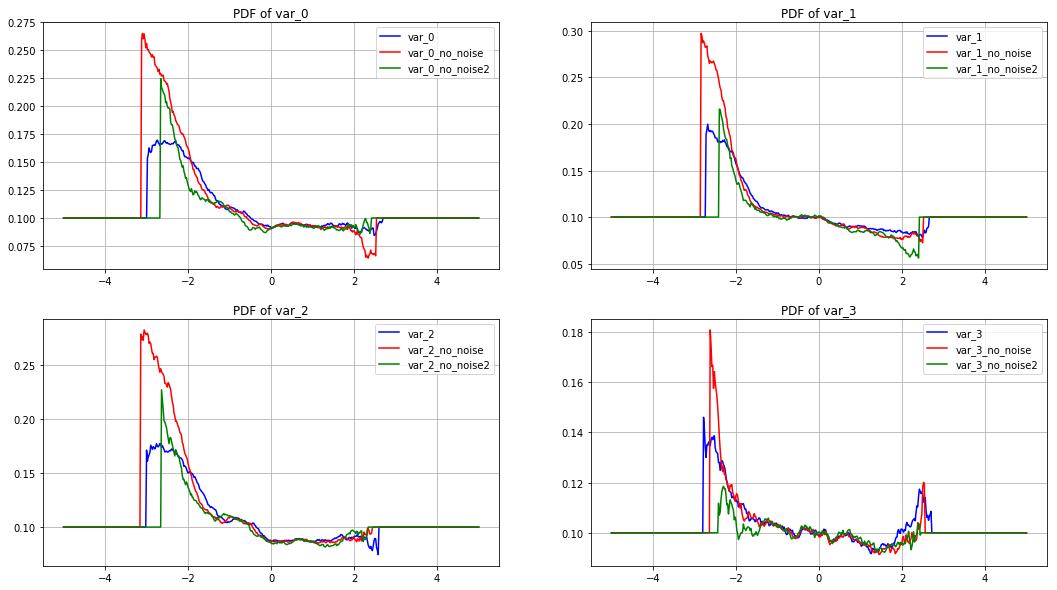

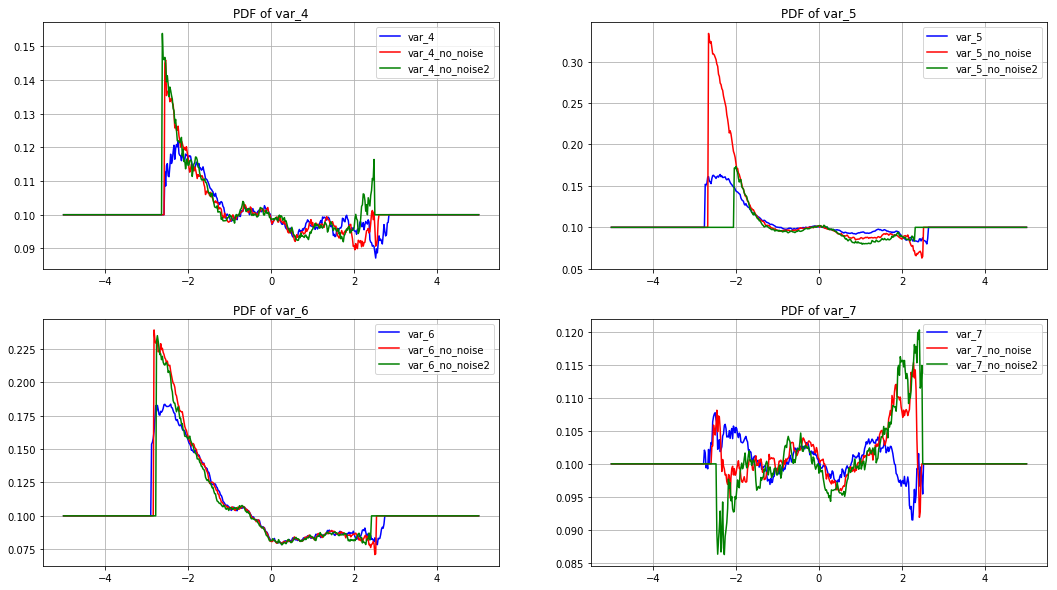

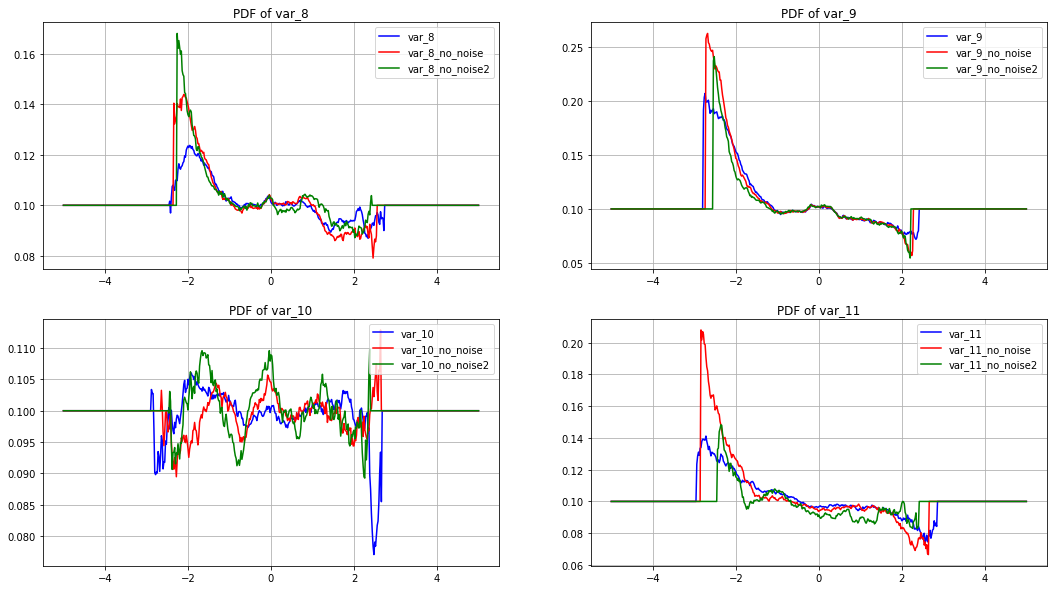

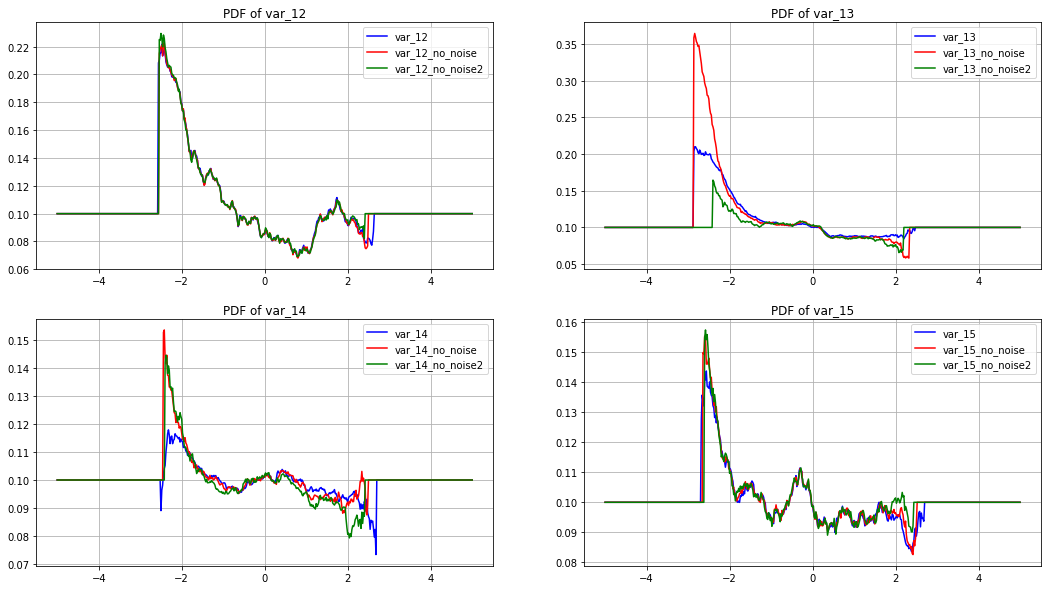

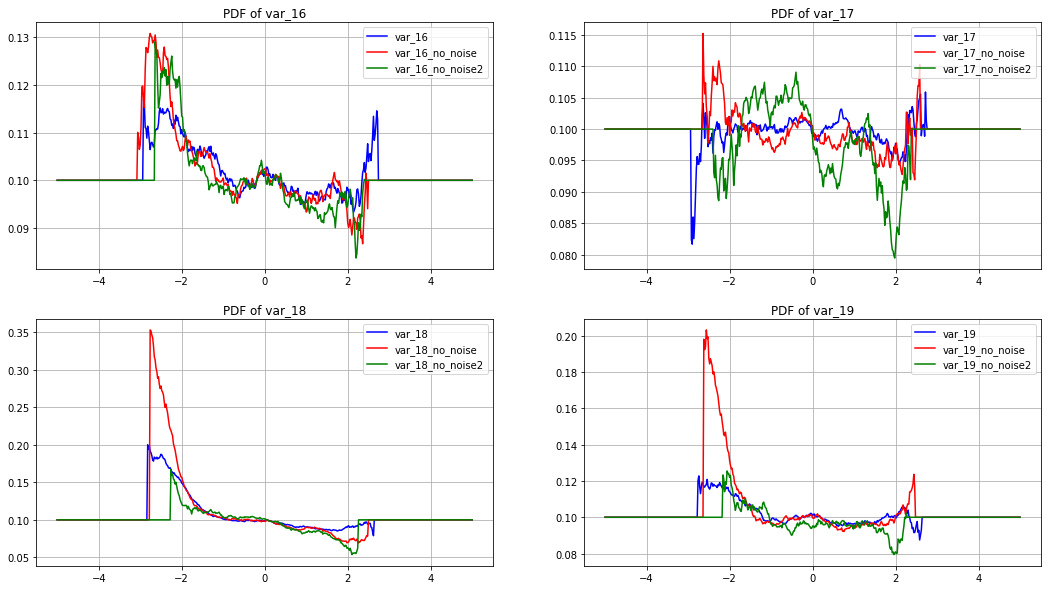

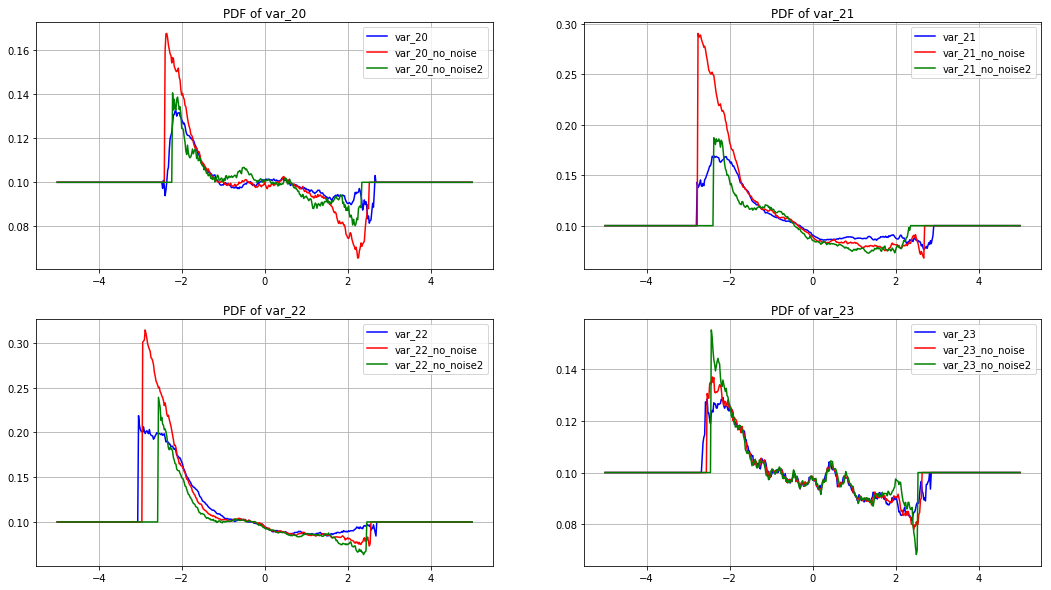

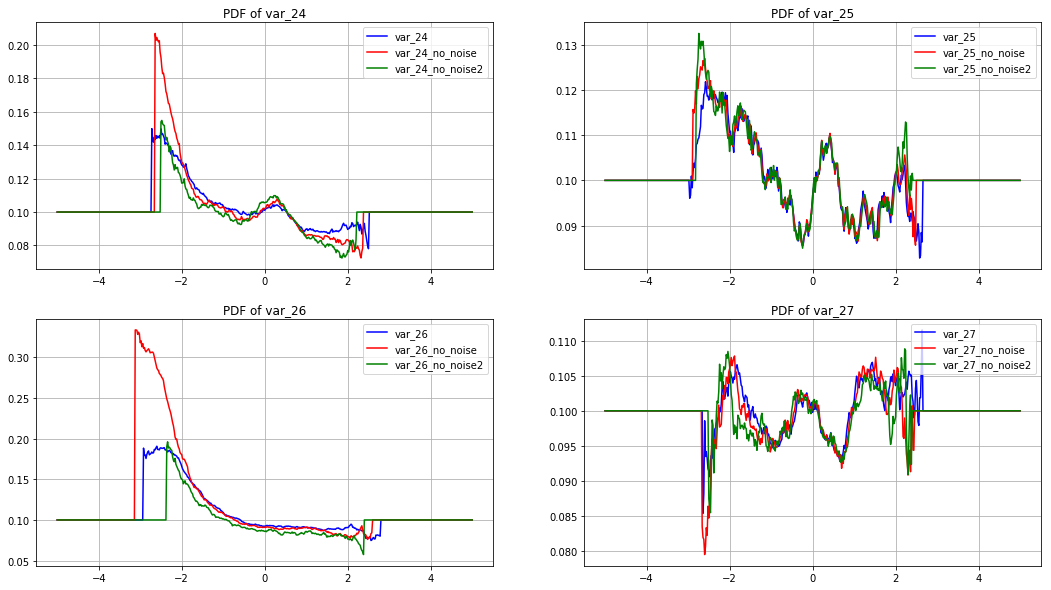

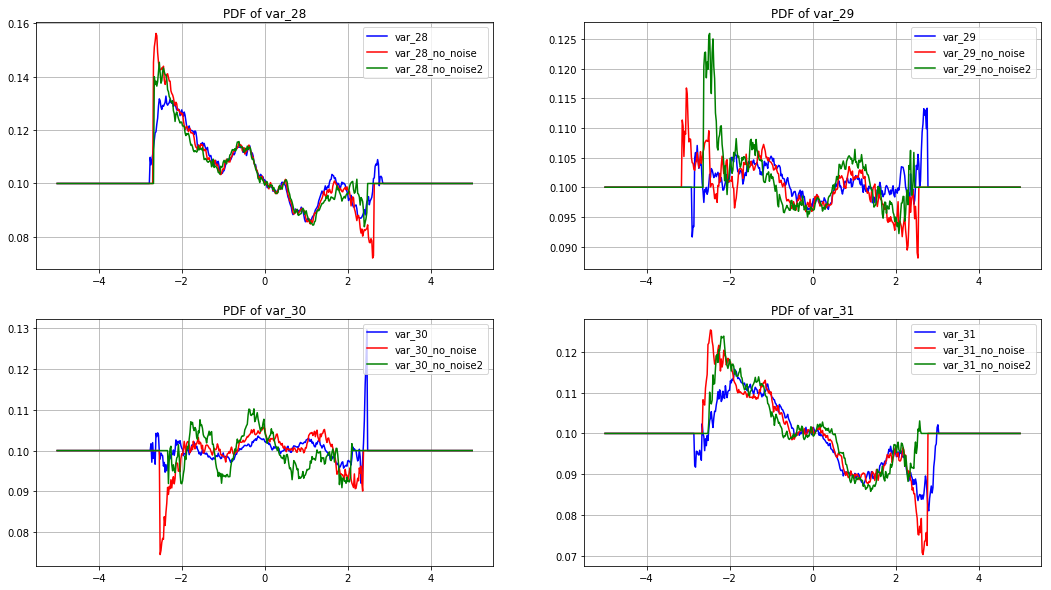

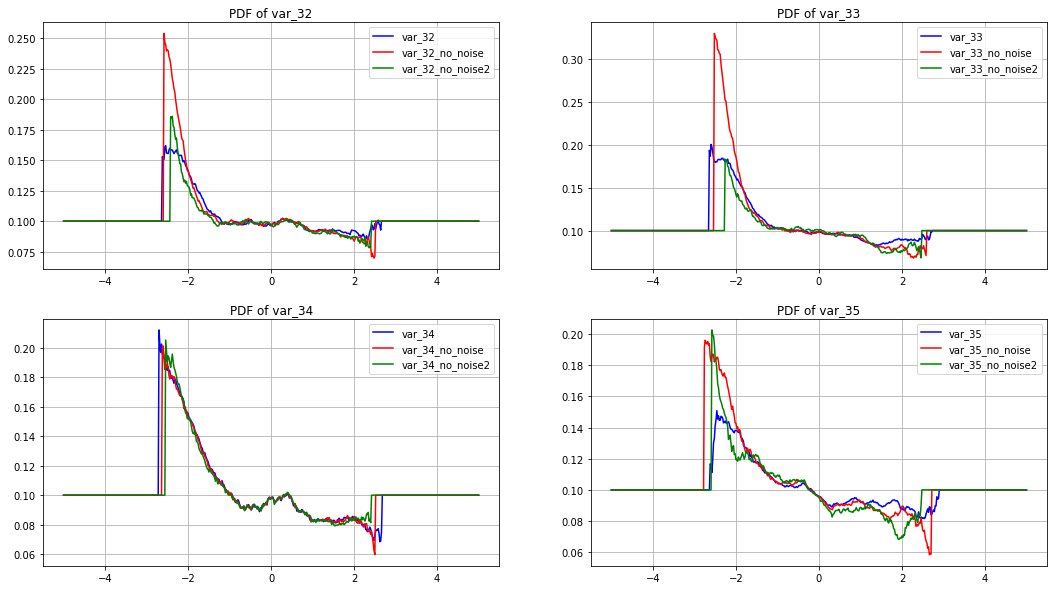

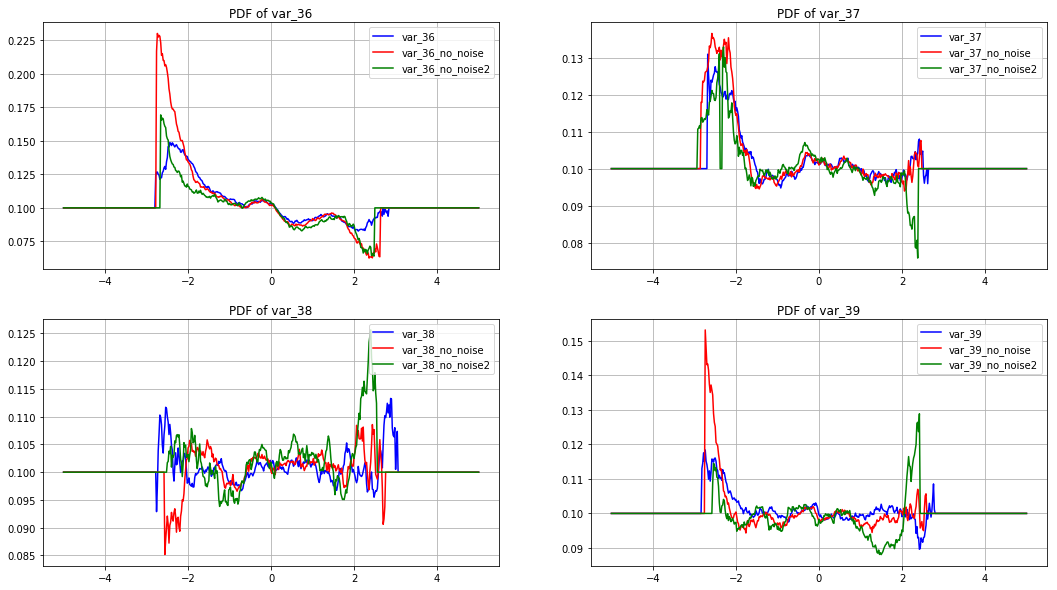

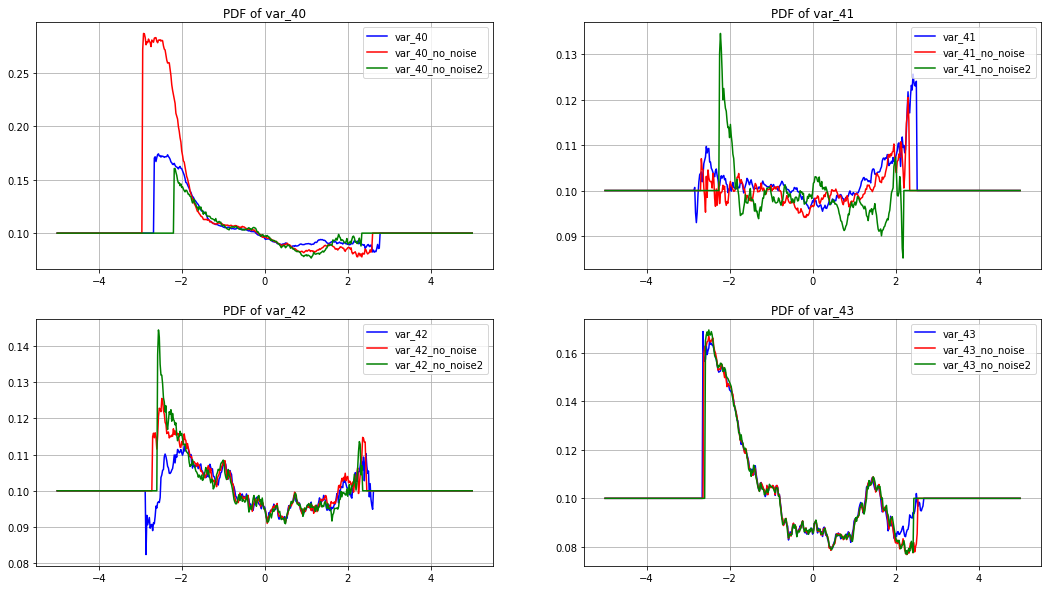

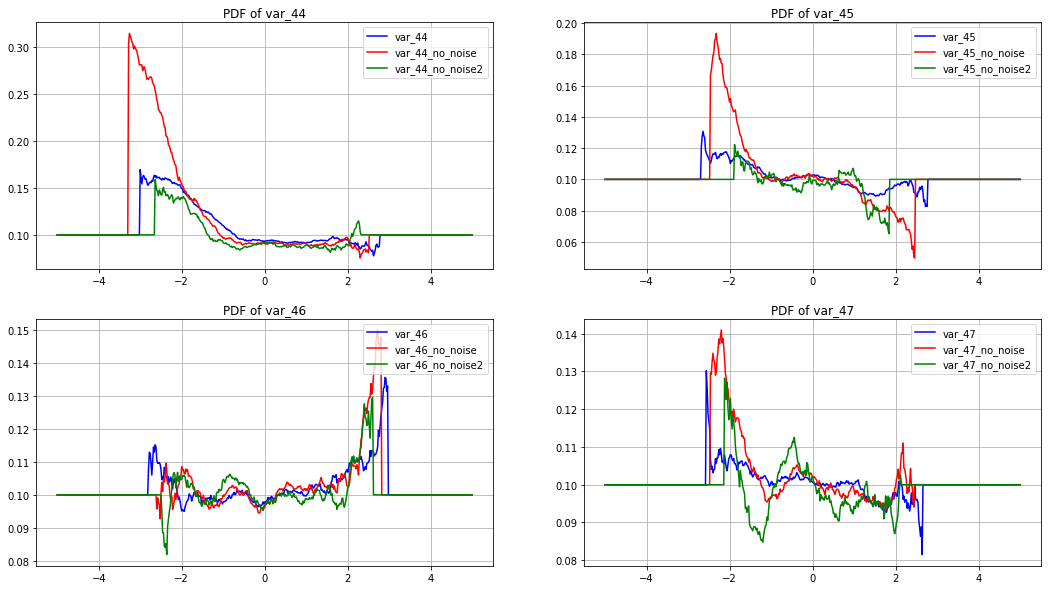

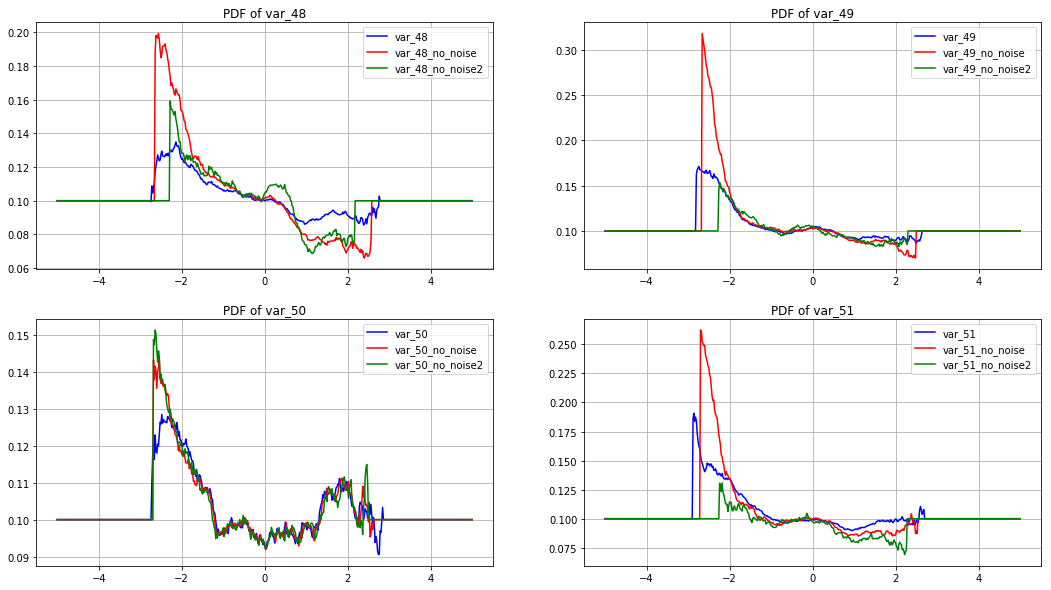

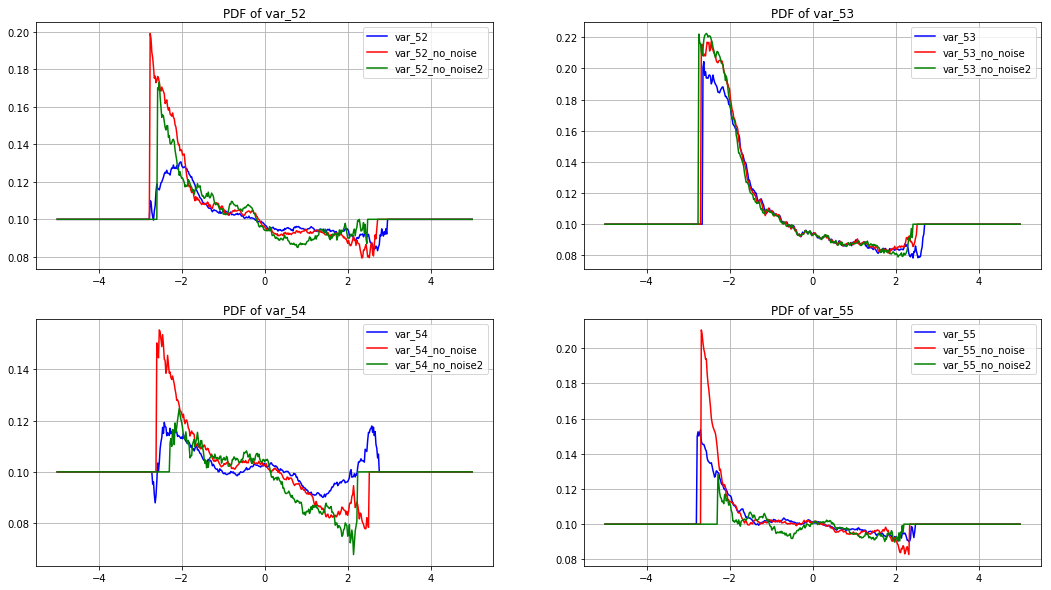

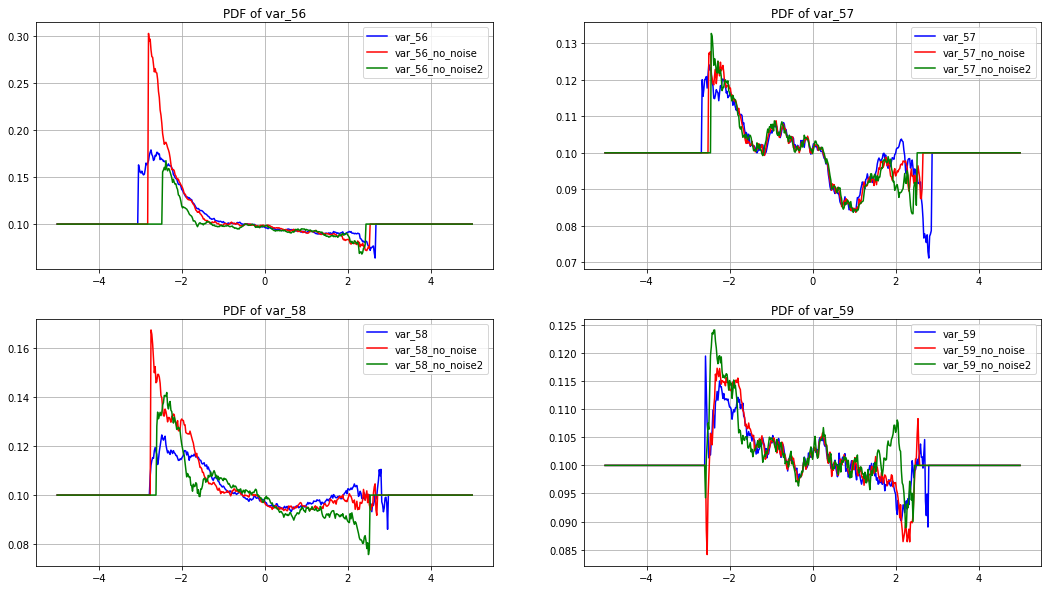

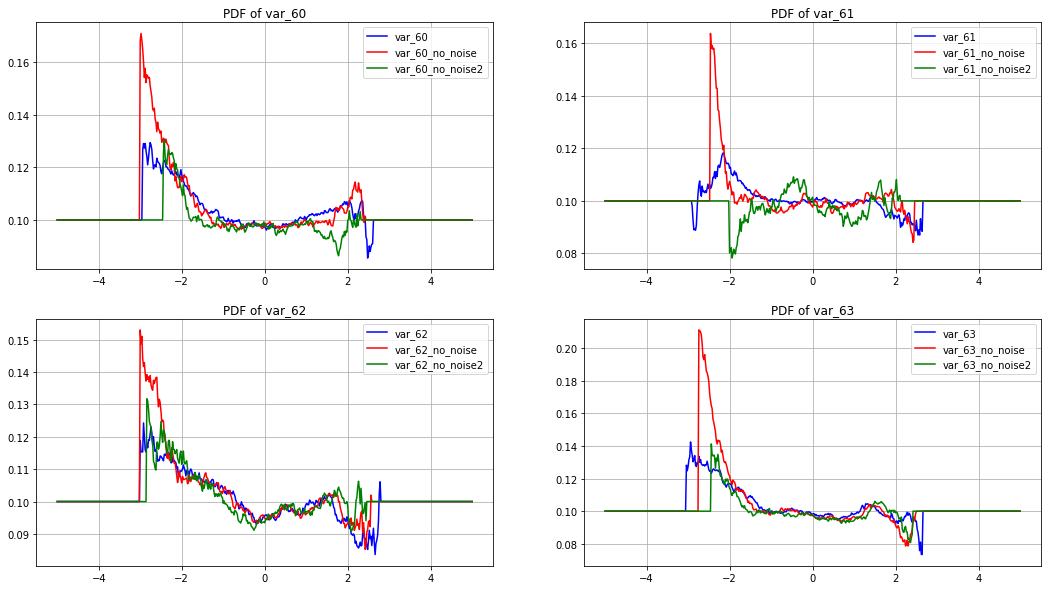

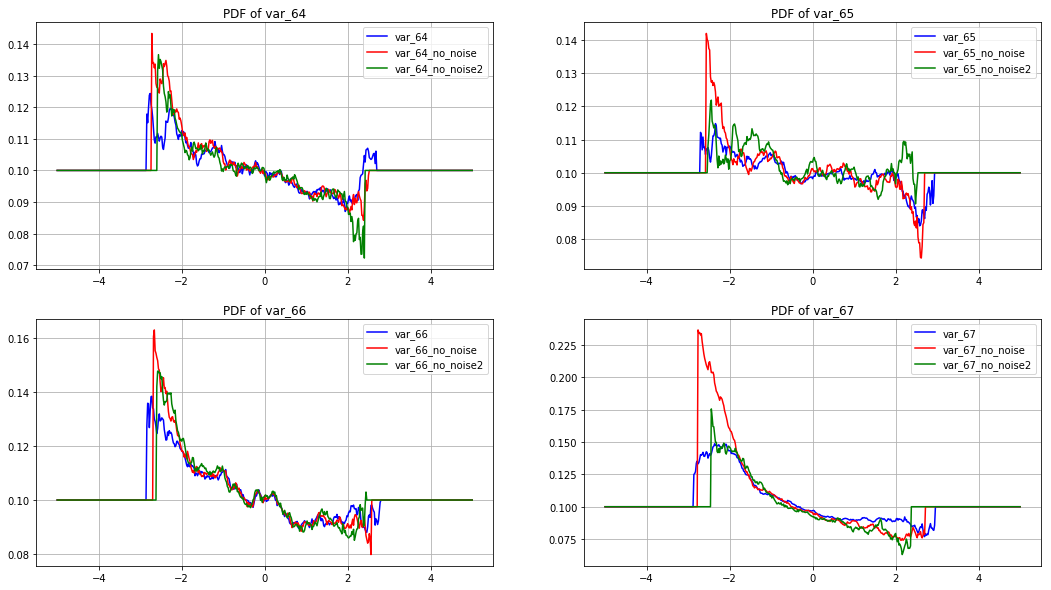

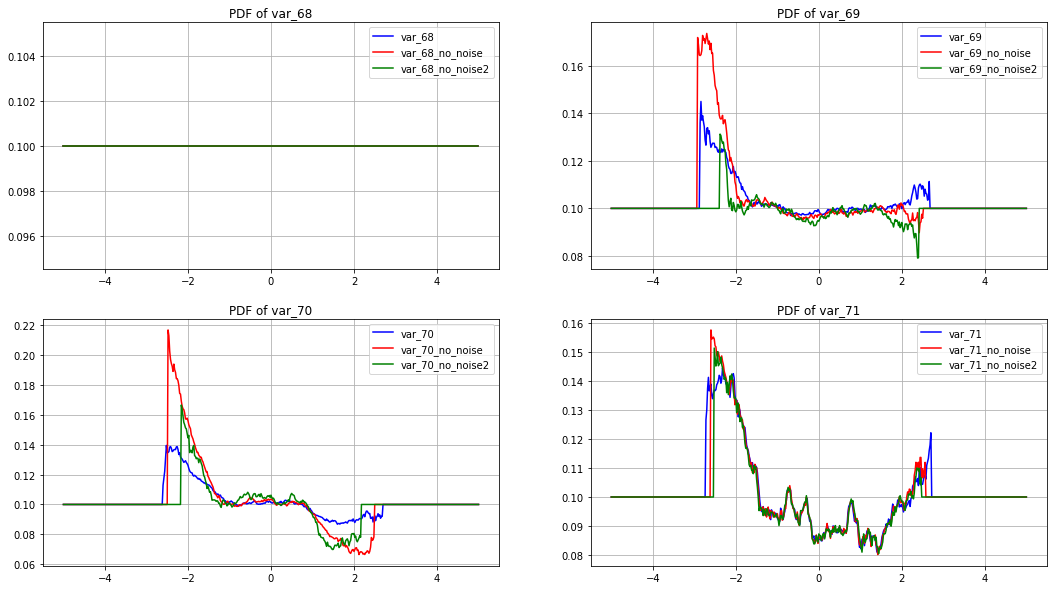

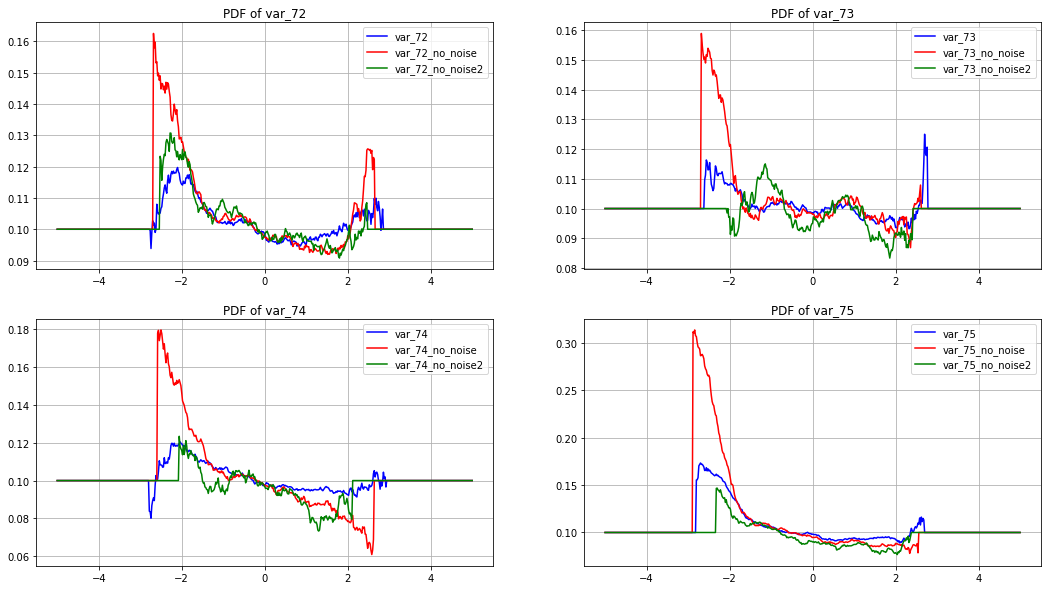

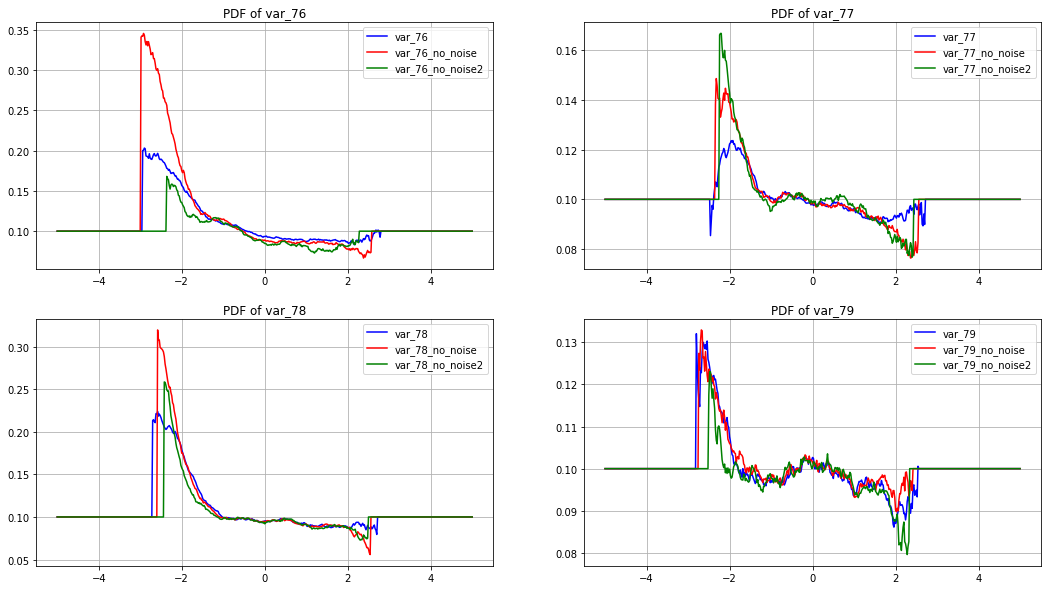

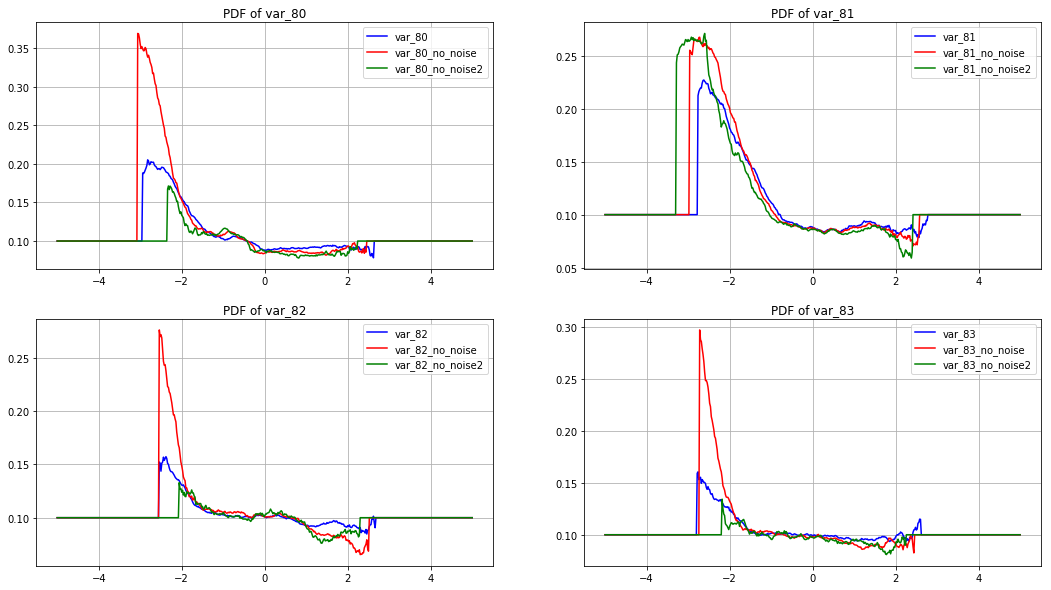

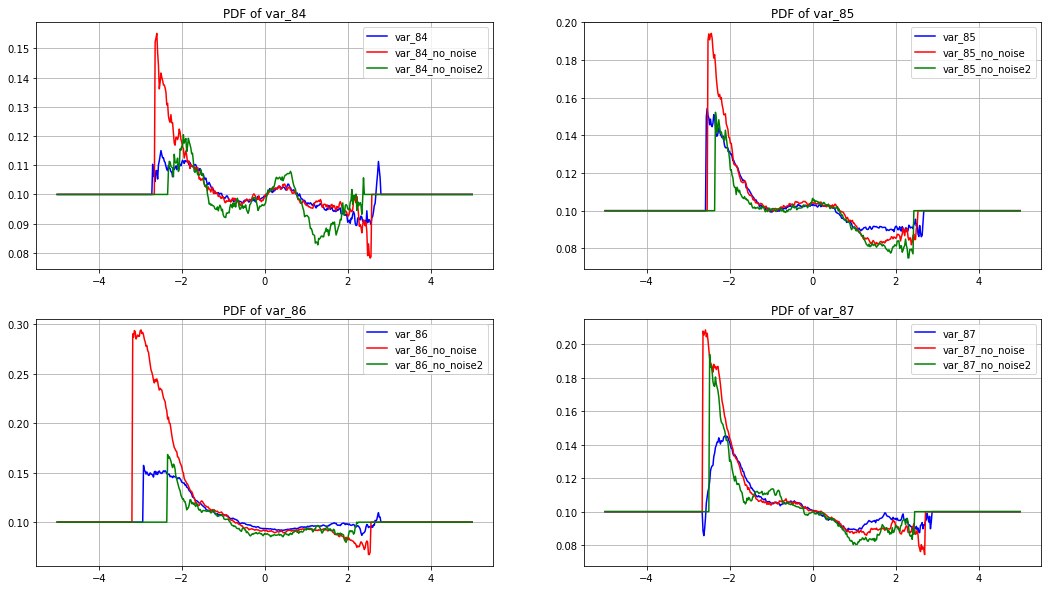

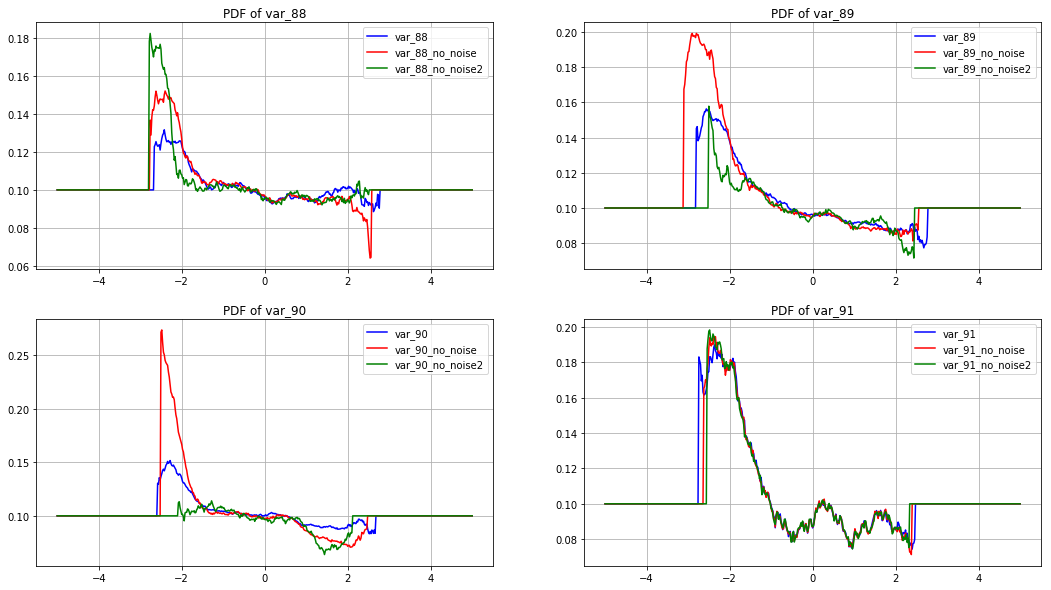

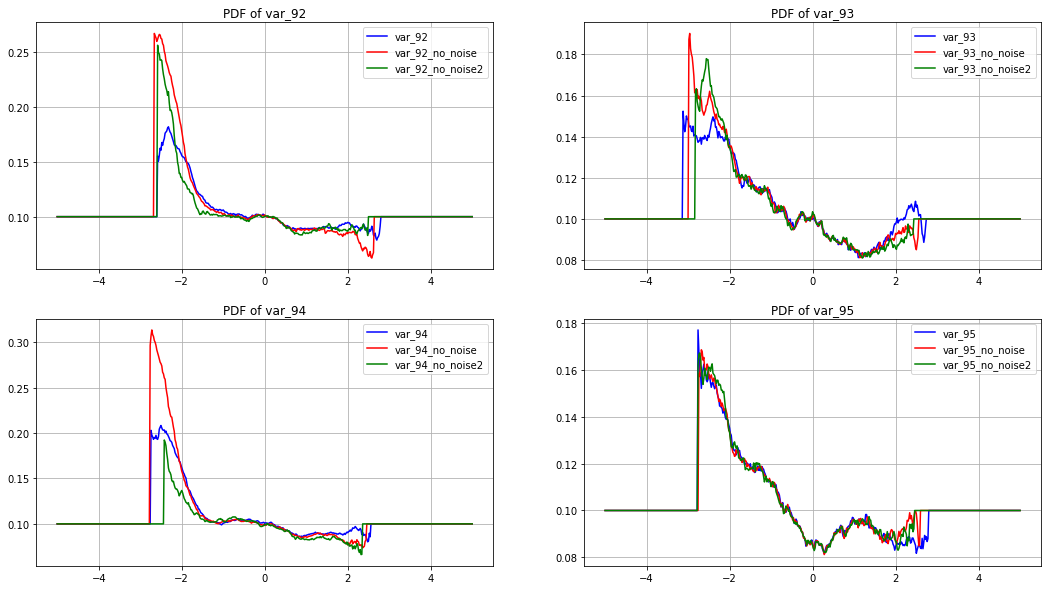

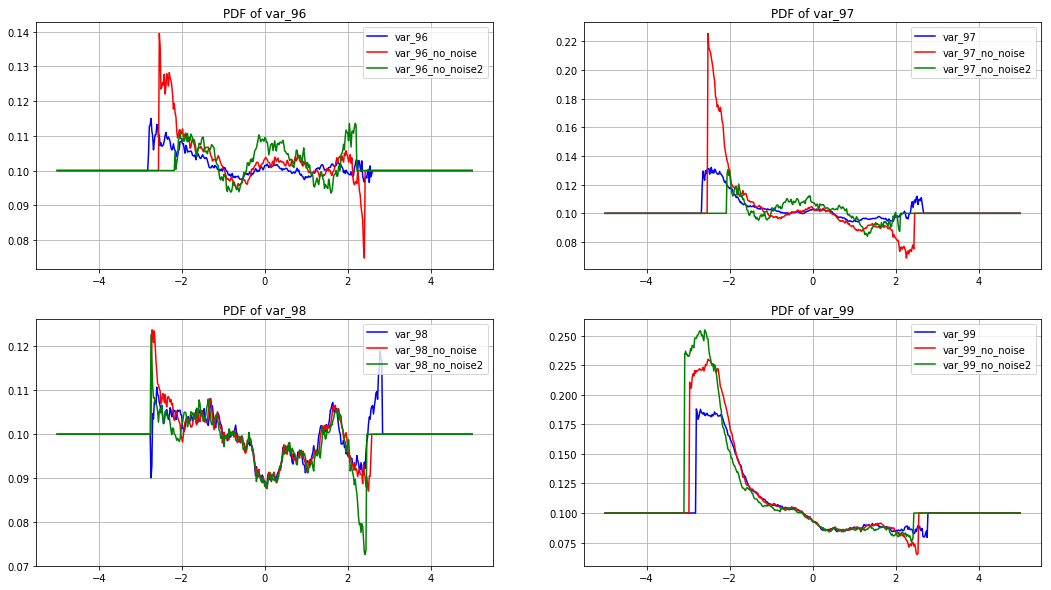

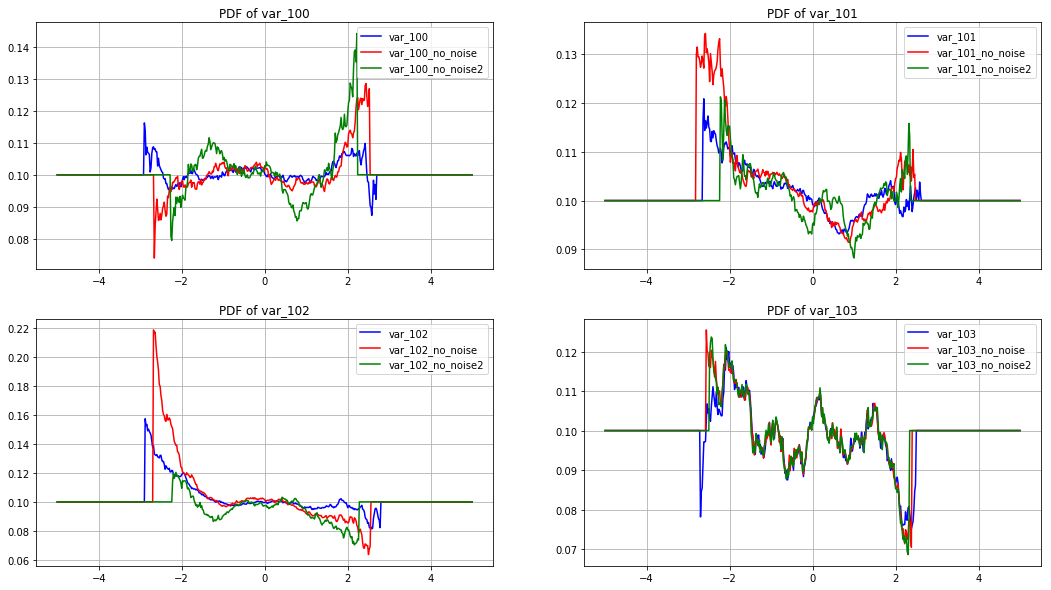

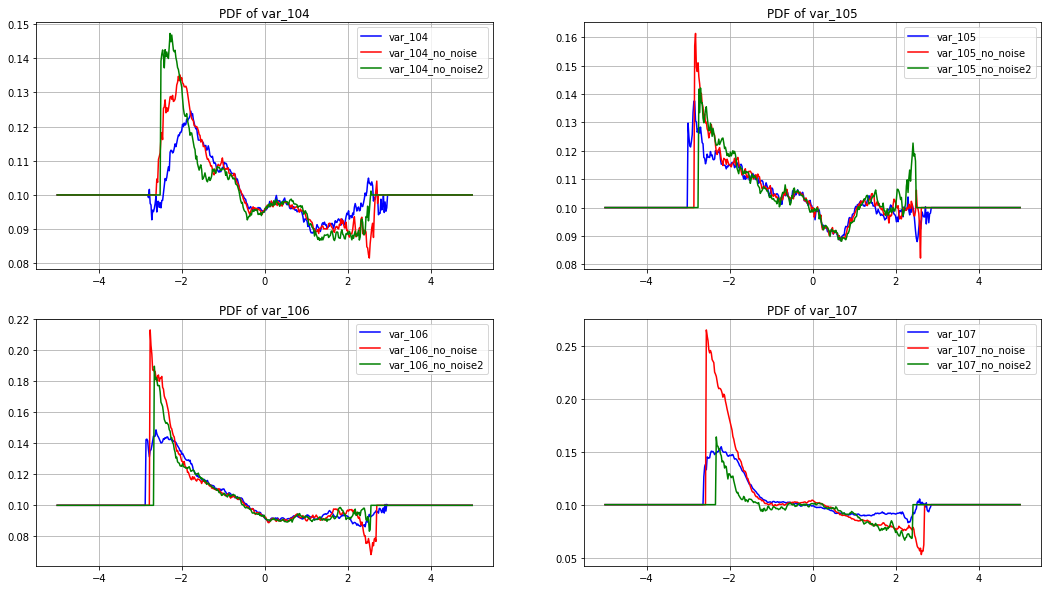

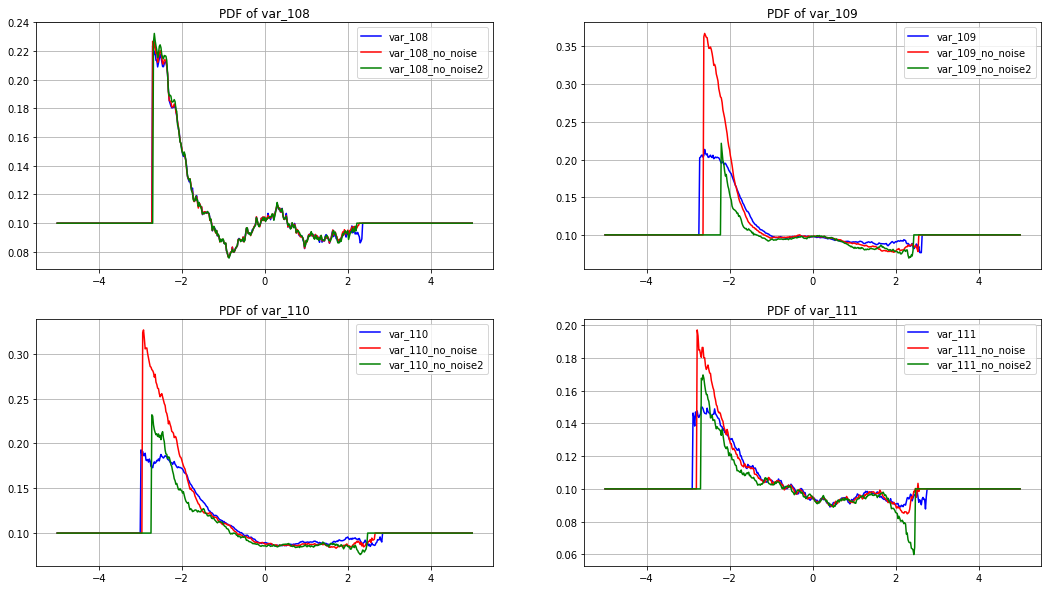

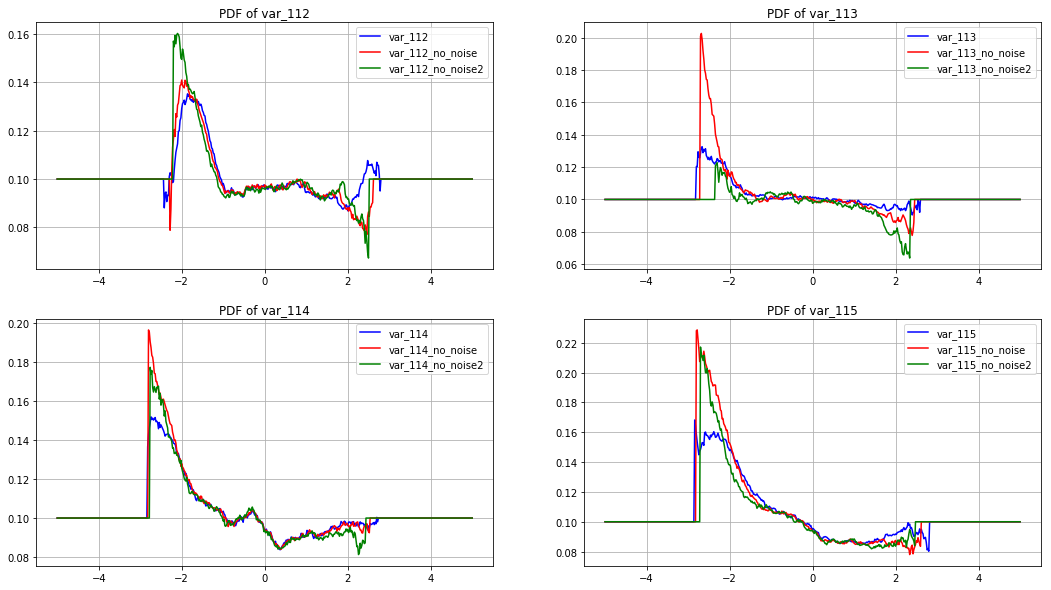

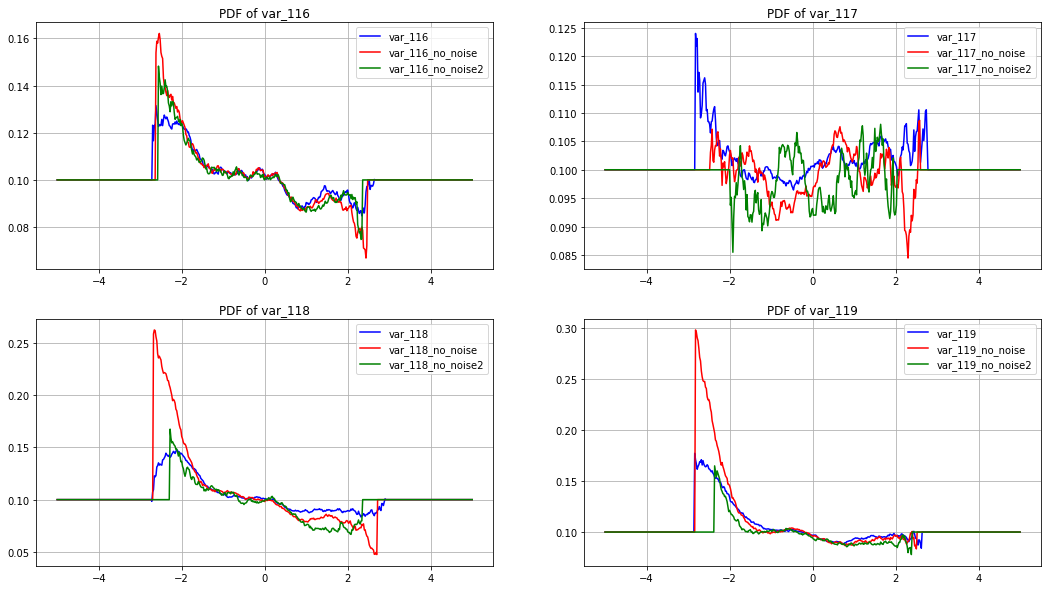

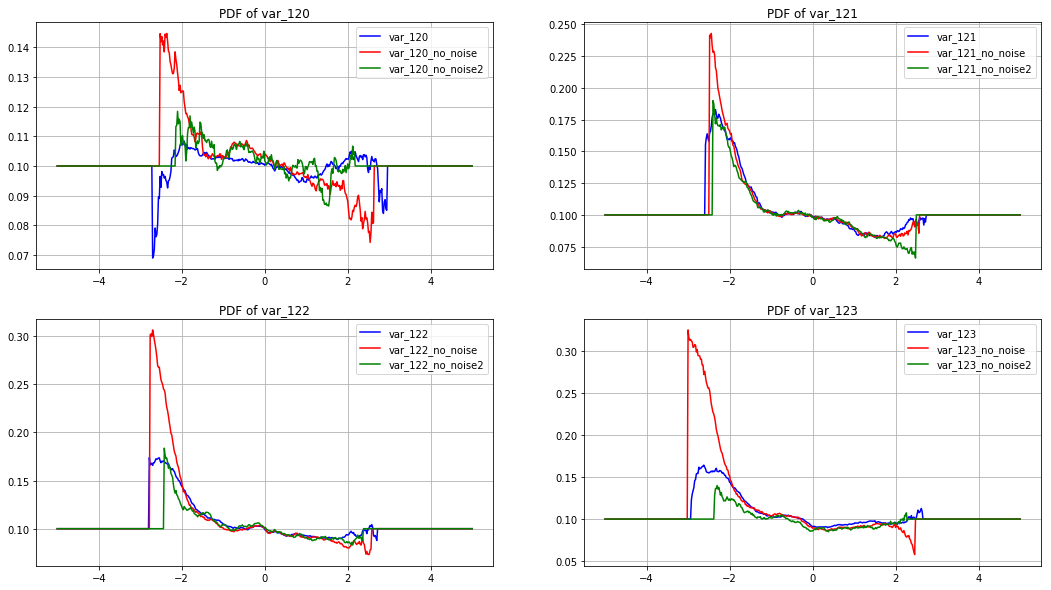

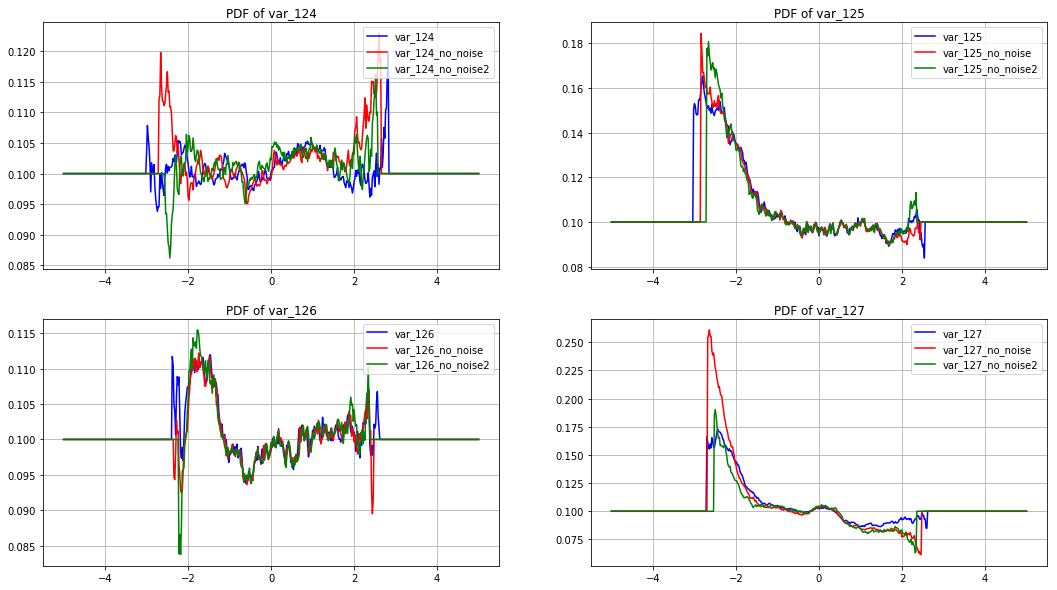

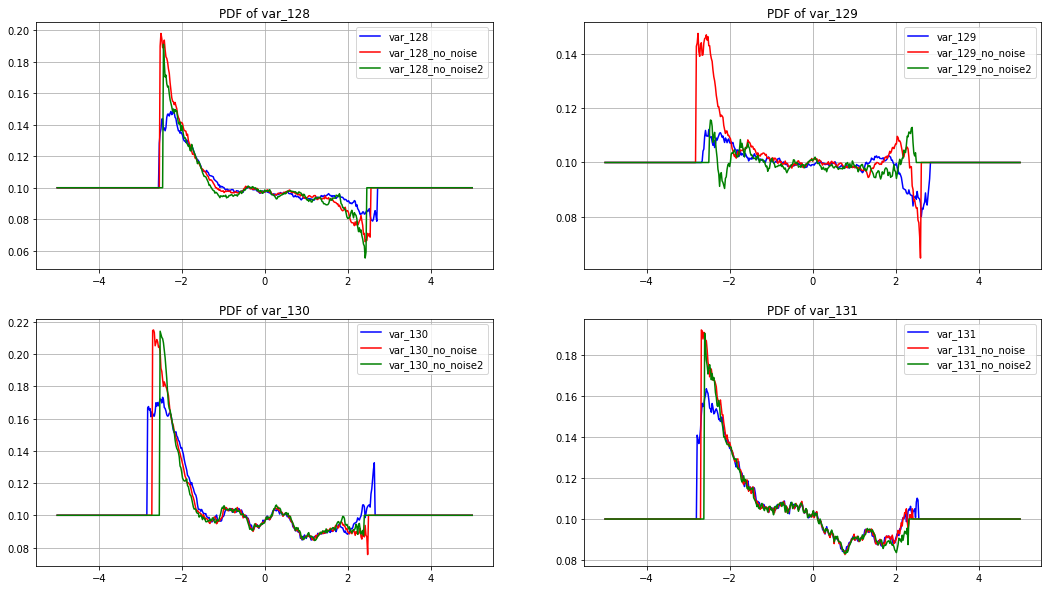

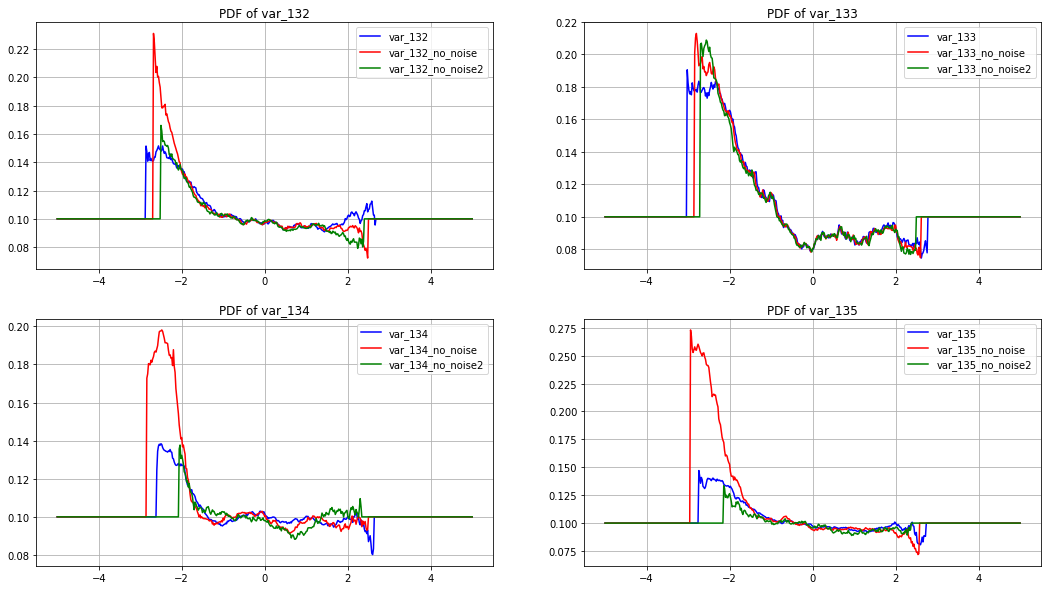

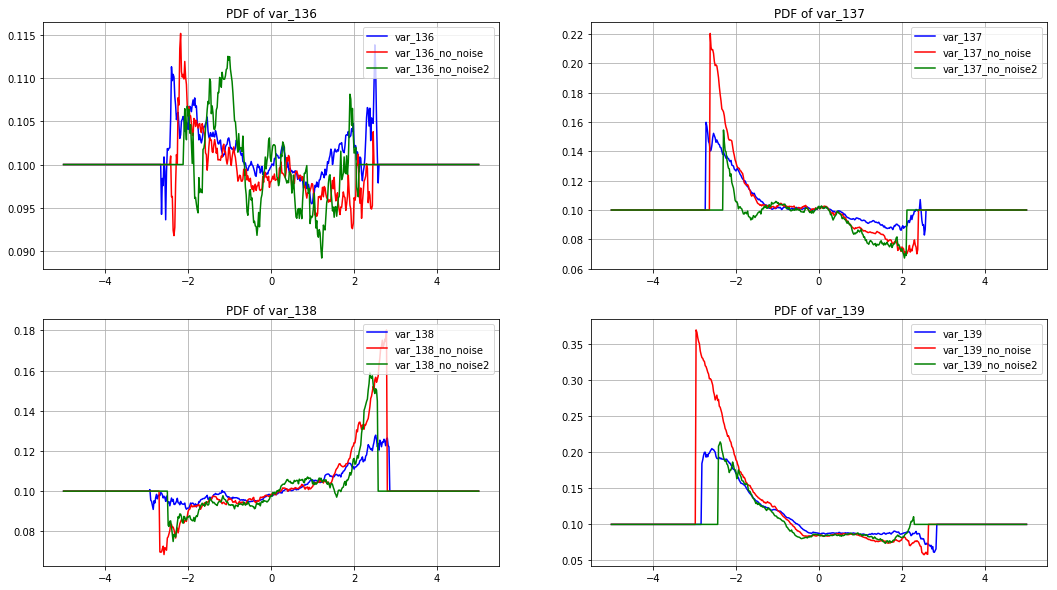

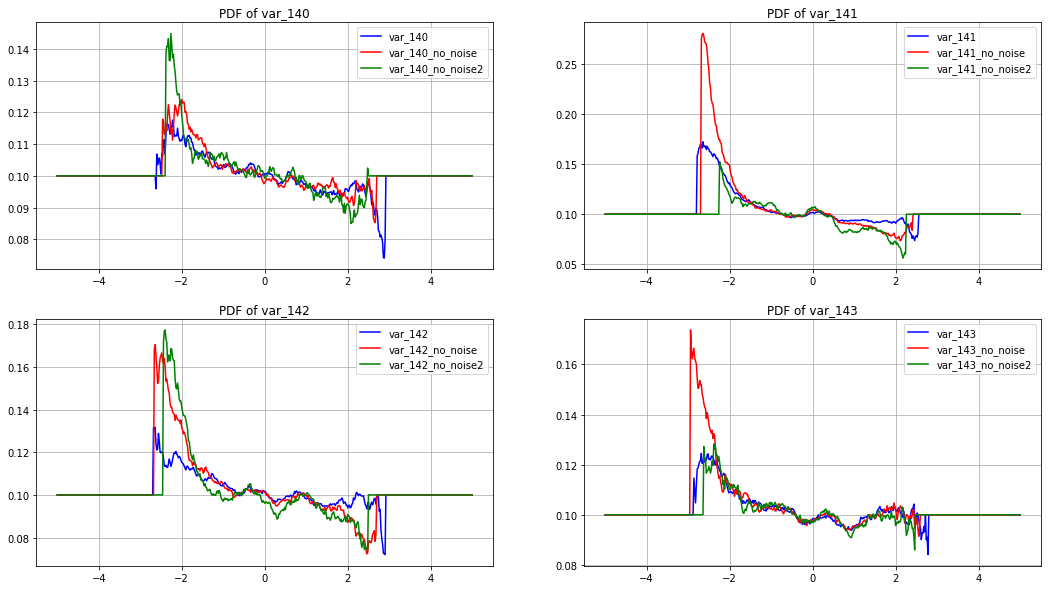

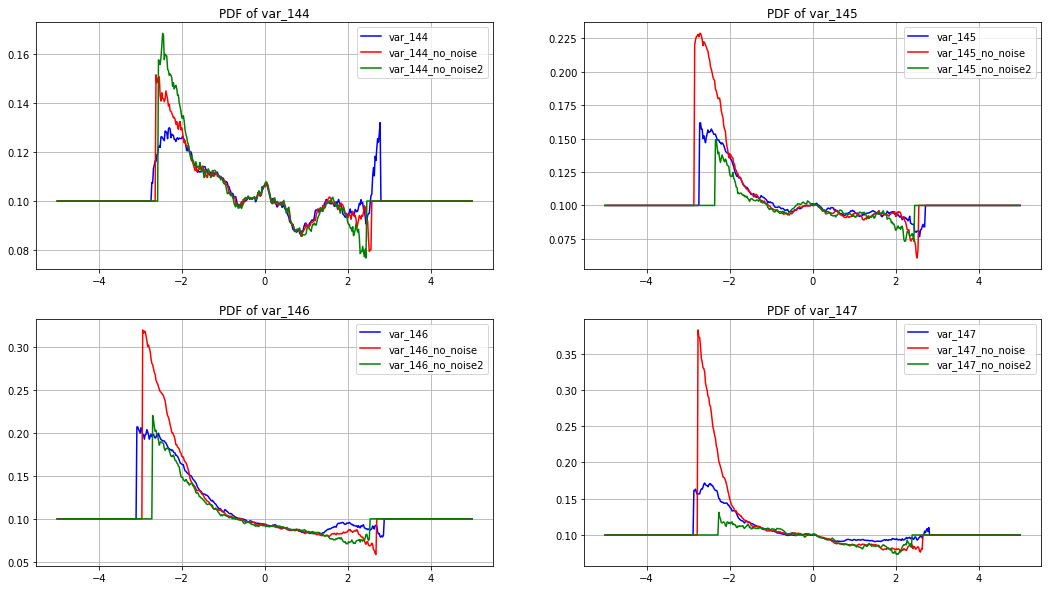

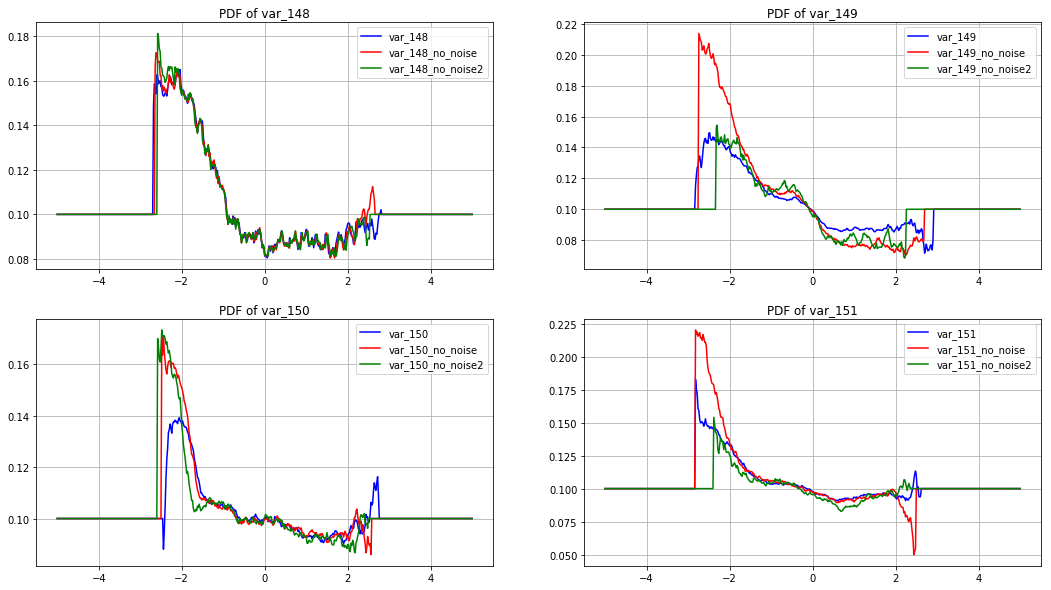

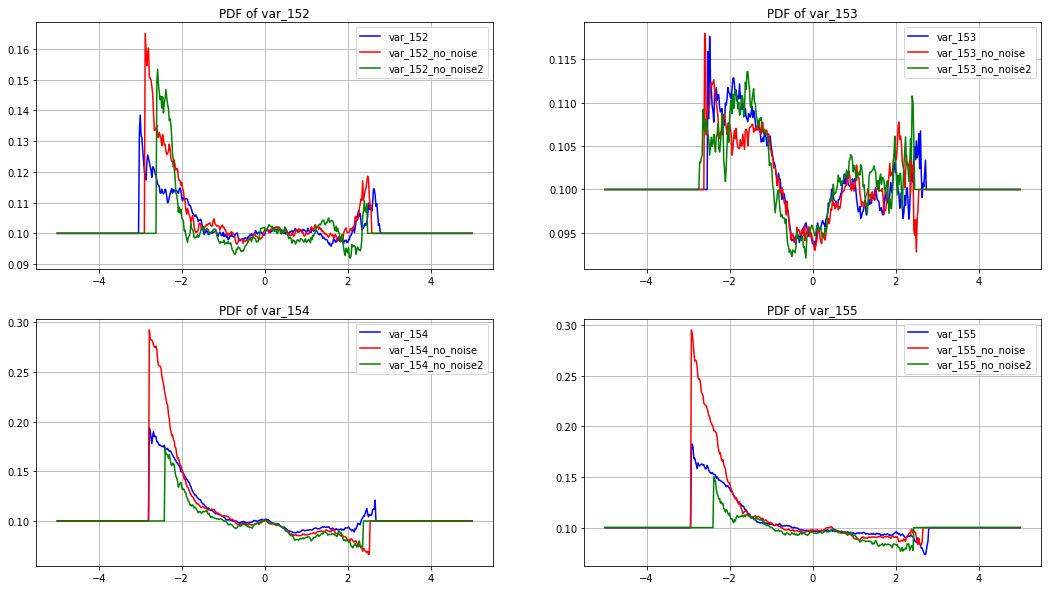

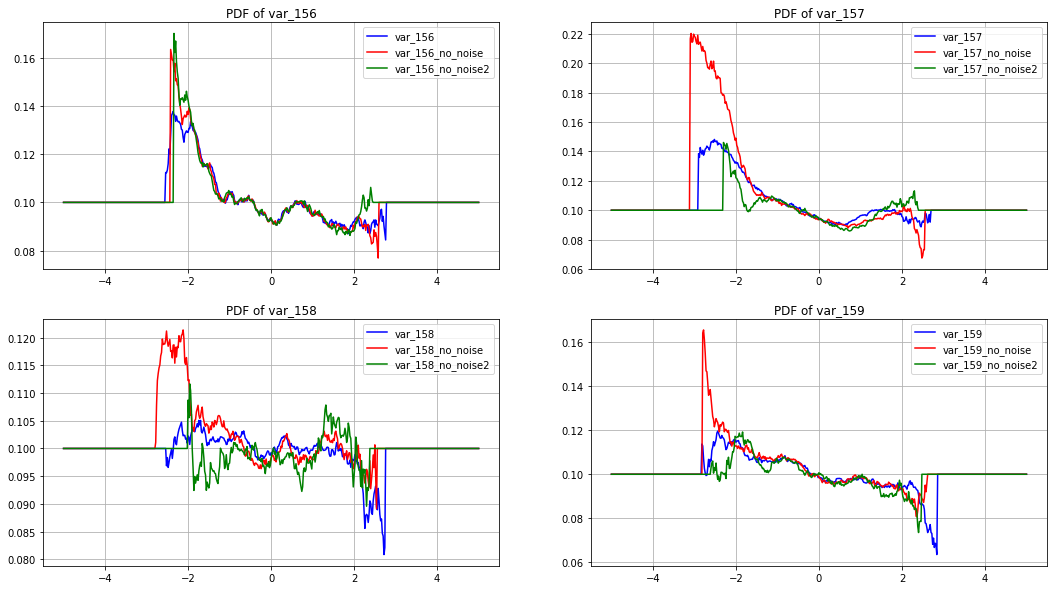

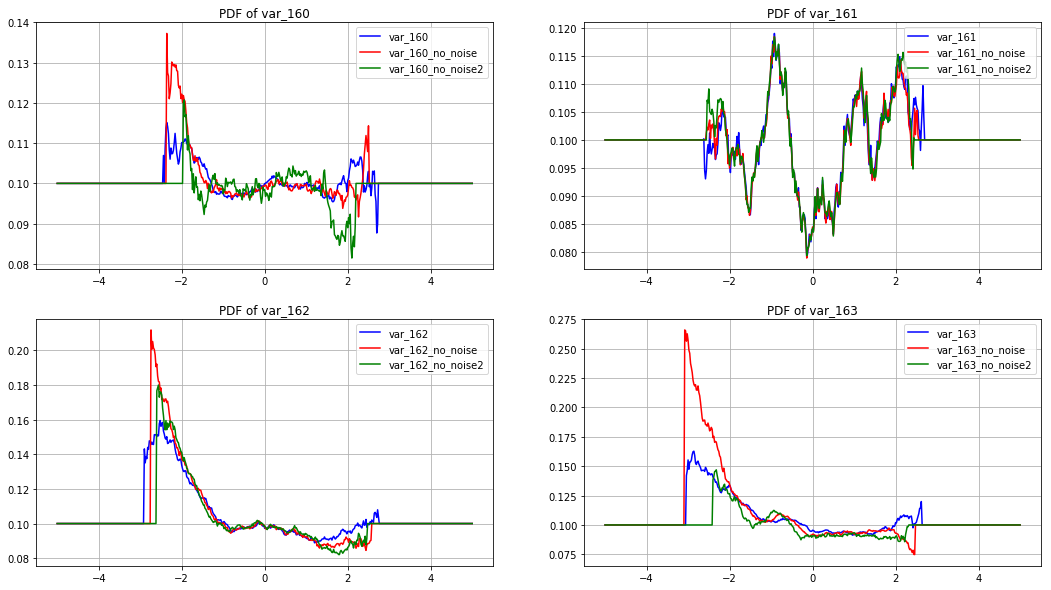

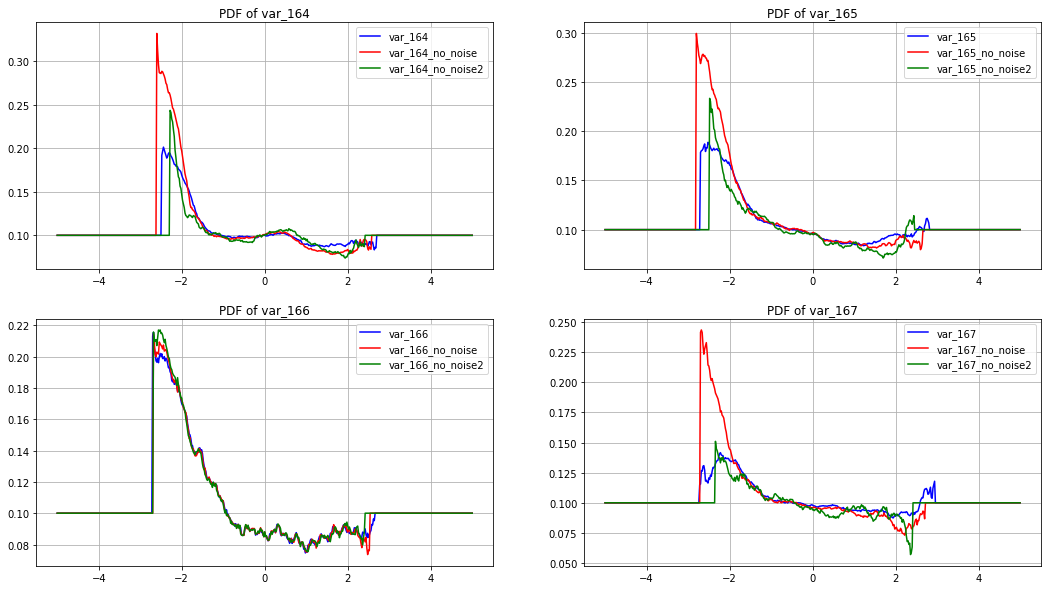

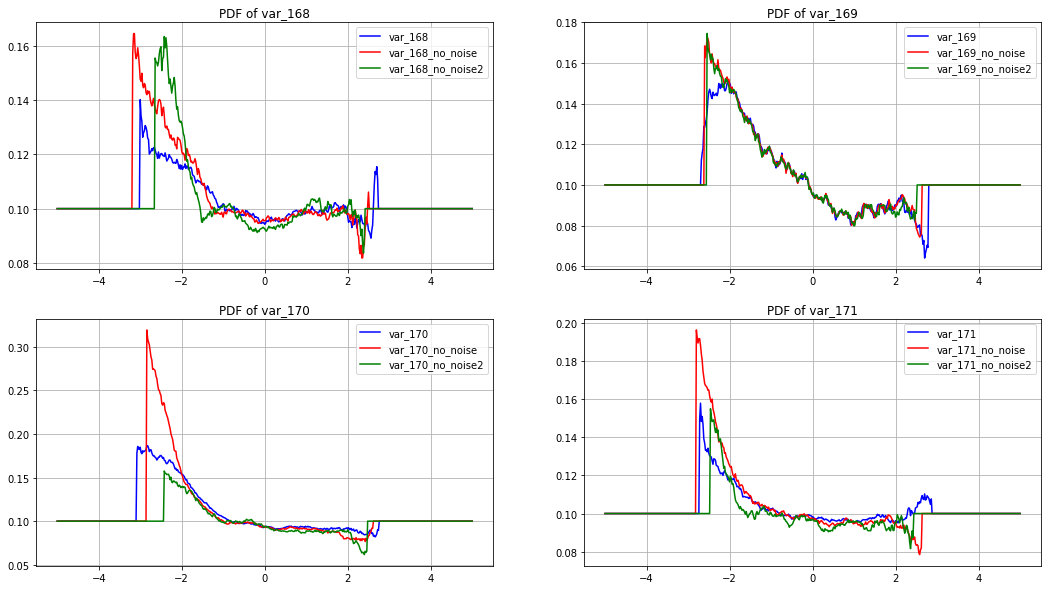

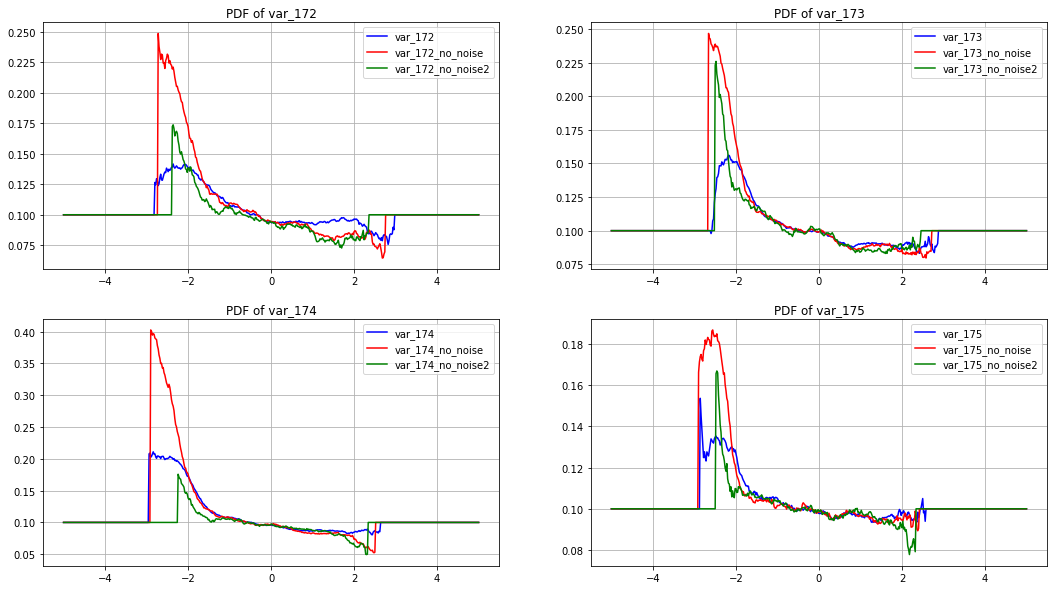

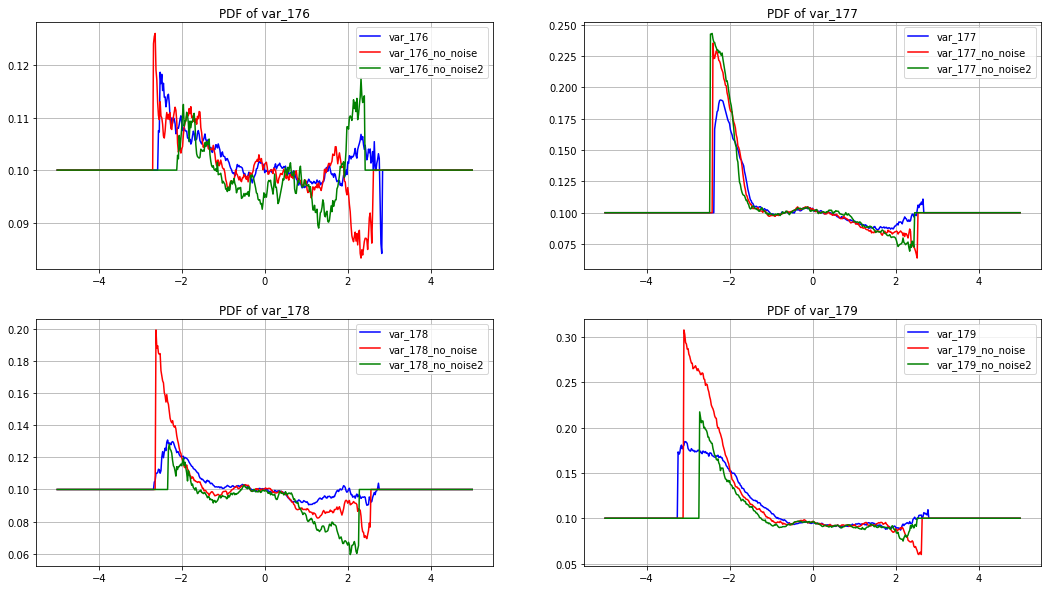

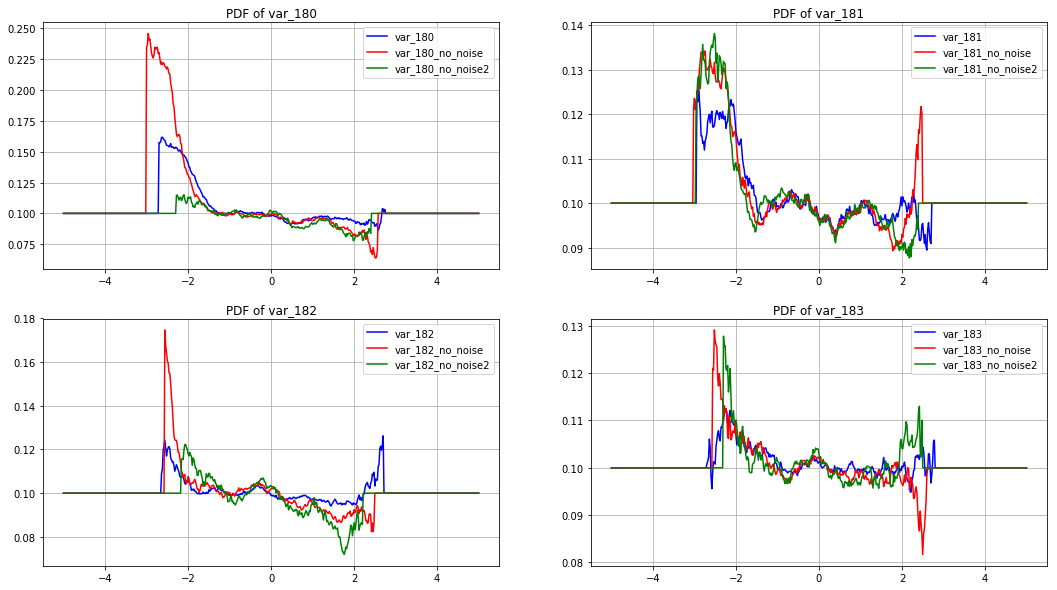

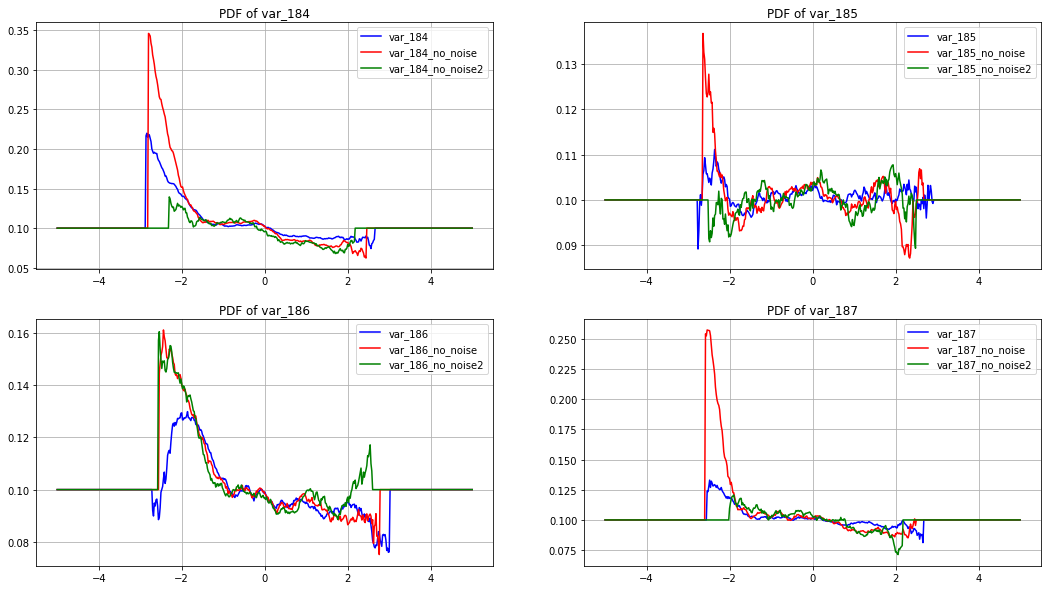

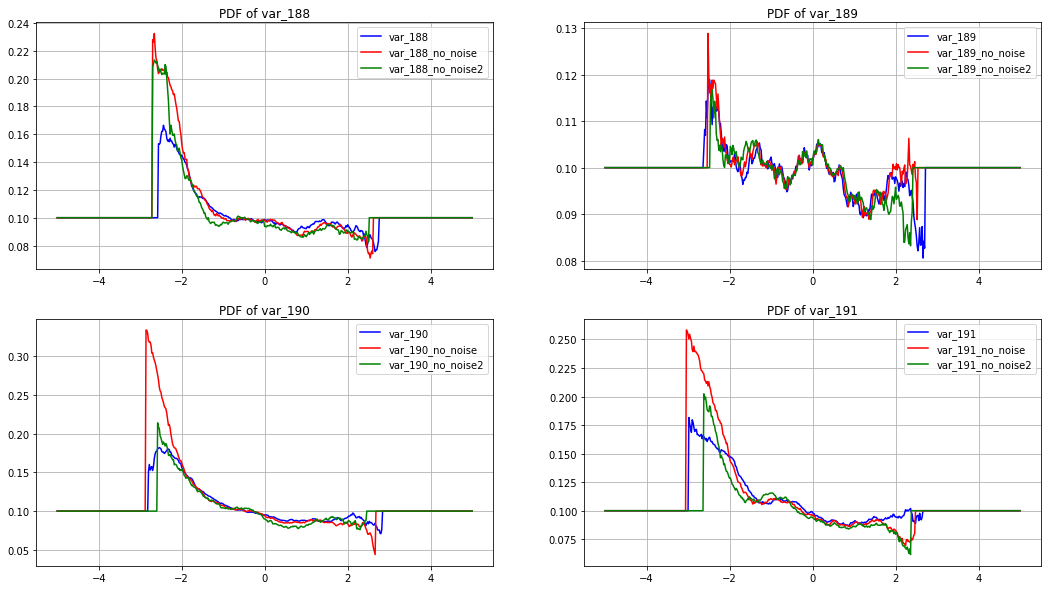

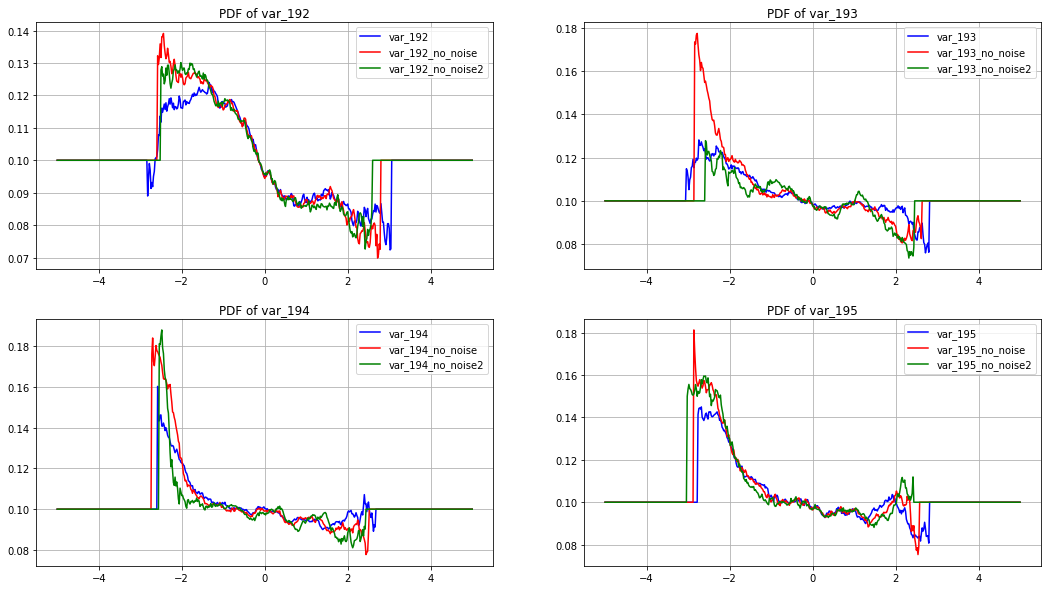

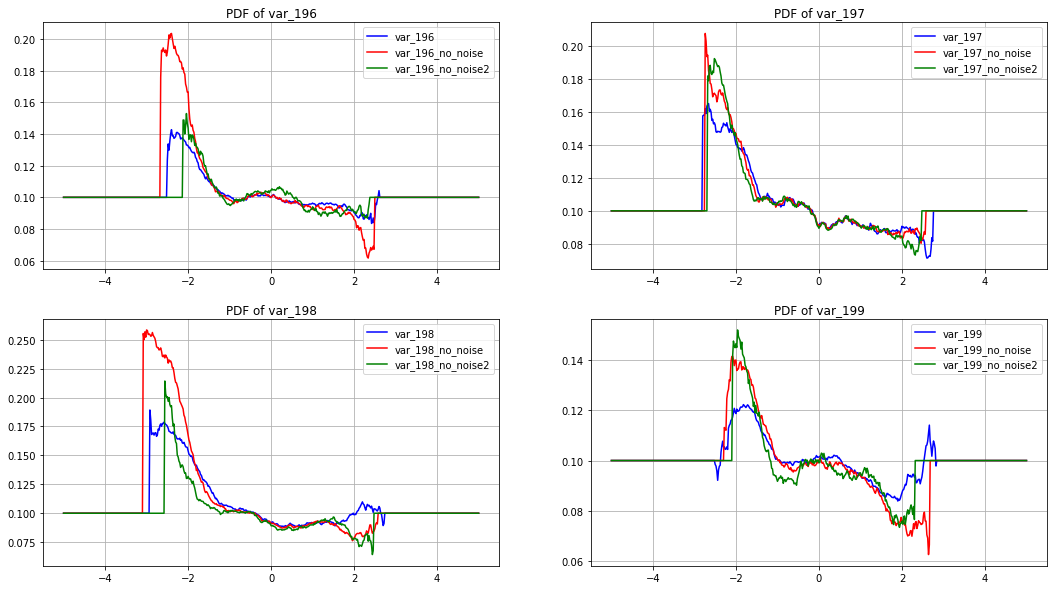

In [30]:
plot_pdfs(tr)